# TODO

# Load data

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

from iterativennsimple.Sequential2D import Sequential2D, Identity
from iterativennsimple.Sequential1D import Sequential1D

from iterativennsimple.utils.plot_2D_start_end import plot_2D_start_end

In [2]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [3]:
#name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'
#one_hot_y = False

name = 'MNIST'
one_hot_y = True

# Read the start data
z_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
z_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')

## Data preprocessing

In [4]:
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)

# Only use the given number of sample
max_num_samples = 1000
num_samples = min(max_num_samples, z_start_tensor.shape[0])
z_start_tensor = z_start_tensor[:num_samples]
z_target_tensor = z_target_tensor[:num_samples]


We have two views of the data, and here is where we reconcile them.   The dynamical systems view is to have vector $z_0$ (called "z_start_tensor" in the code) and $z_1$ (called "z_target_tensor" in the code) that are the initial and final states of the system.  We want to construct a function $f$ (or more precisely choose a set of parameters $\theta$ that selects $f$ from some family of functions) such that $\|f(z_0) - z_1\|$ is small.  The machine learning view is to have a set of inputs $x$ (which is a subset of "z_start_tensor") and a set of outputs $y$ (which is a subset of "z_target_tensor") and to construct a function $g$ (or more precisely choose a set of parameters $\phi$ that selects $g$ from some family of functions) such that $\|g(x) - y\|$ is small.   

**The idea is to have $x$ and $y$ be subsets of $z_0$ and $z_1$ respectively!**   But how to do that!?

Let's begin by writing 

$$
z_i=
\begin{bmatrix}
x_i \\
y_i \\
\end{bmatrix}
$$

and **we assume that $x_0=x_1$**.  This may seem odd at first glance, but is actually quite natural.  For example, in our MNIST example the starting image in $x_0$ and the target image in $x_1$ are the same.  It is merely the classification in $y_0$ and $y_1$ that are different.  I.e., $y_0$ contains some noisy classification or uniform prior of $x_0$ and $y_1$ contains the correct classification of $x_0$.  In the case of the MNIST data, we have $x_0=x_1$ and $y_0\neq y_1$.

So, in slighltly more detail we choose $z_0$ and $z_1$ so that

$$
z_0=
\begin{bmatrix}
x_0 \\
y_0 \\
\end{bmatrix}
$$

and

$$
z_1=
\begin{bmatrix}
x_0 \\
y_1 \\
\end{bmatrix}
$$

In [5]:

# compute a mask for the data where every entry in each column is the same
# this is used to remove columns that are constant
mask = (z_start_tensor == z_target_tensor).all(axis=0)
mask.shape
x_mask = mask
y_mask = ~mask

# print out the shape of the masks
print(x_mask.shape, y_mask.shape)

# print out number of true entries in each mask
print(x_mask.sum(), y_mask.sum())


torch.Size([794]) torch.Size([794])
tensor(784) tensor(10)


# MLP model

Now we start using Sequential2D to build our model.  This requires a little massaging of the data.  In particlar, remember that we now have an iterative map of the form

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
$$

and a state vector that combines $x$, $y$, and *the hidden layers* in the following way.

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
x_0 \\
h_1 \\
h_2 \\
y_0 \\
\end{bmatrix}
$$

I am feeling a little silly today, so let's do the rest using Achilles and the Hare from Godel, Escher, Bach.

![image.png](attachment:image.png)

Achilles:  But... didn't you just say that an normal ML algorithm link and MLP ignores $y_0$?  Look, doesn't $y_0$ appear right up there?  

Hare: Well, look at what happens after the first iteration.

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
x_0 \\
h_1 \\
h_2 \\
y_0 \\
\end{bmatrix}
=
\begin{bmatrix}
x_0 \\
f_1(x_0) \\
f_2(h_1) \\
f_3(h_2) \\
\end{bmatrix}
$$

which **does not** contain $y_0$!  The MLP is cunningly designed to ignore the initial guess contained in $y_0$ :-)

Achilles:  But... but... but...  what about the hidden layers $h_1$ and $h_2$?  Don't you need to choose them carefully since they are the input to the next layer\iteration?  I remember reading that MLPs don't care about random initializations of the hidden layers since they will be overwritten by the training process!?

Hare: Yes, but...  look at what happens after the second iteration.

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
x_0 \\
h_1 \\
h_2 \\
y_0 \\
\end{bmatrix}
=
\begin{bmatrix}
x_0 \\
f_1(x_0) \\
f_2(f_1(x_0)) \\
f_3(f_2(h_1)) \\
\end{bmatrix}
$$


Hare: And one more iteration gives

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
x_0 \\
h_1 \\
h_2 \\
y_0 \\
\end{bmatrix}
=
\begin{bmatrix}
x_0 \\
f_1(x_0) \\
f_2(f_1(x_0)) \\
f_3(f_2(f_1(x_0))) \\
\end{bmatrix}
$$

Two neat things have happened. First notice that the hidden layers $h_1$ and $h_2$ have been overwritten by the training process, so their initiationlization is irrelevant.  Second, we have the last entry has the form $f_3(f_2(f_1(x_0)))$ which is exactly the form of the answer that the MLP would have given!

Hare:  So, the MLP is a cunningly designed iterative map that ignores the initial guess $y_0$ and the hidden layers $h_1$ and $h_2$ and gives the same answer as the iterative map that we are trying to learn!  

In [6]:
input_size = int(x_mask.sum())
h1_size = 20
h2_size = 20
output_size = int(y_mask.sum())

x_idx = torch.arange(0, input_size)
h_idx = torch.arange(input_size, input_size+h1_size+h2_size)
y_idx = torch.arange(input_size+h1_size+h2_size, input_size+h1_size+h2_size+output_size)

total_size = input_size + h1_size + h2_size + output_size

iterations = 3

I = Identity(in_features=input_size, out_features=input_size)
f1 = Sequential1D(torch.nn.Linear(in_features=input_size, out_features=h1_size), 
                  torch.nn.ReLU(), 
                  in_features=input_size, out_features=h1_size)
f2 = Sequential1D(torch.nn.Linear(in_features=h1_size, out_features=h2_size), 
                  torch.nn.ReLU(), 
                  in_features=h1_size,    out_features=h2_size)
f3 = torch.nn.Linear(in_features=h2_size,    out_features=output_size)    

in_features_list  = [input_size, h1_size, h2_size, output_size]
out_features_list = [input_size, h1_size, h2_size, output_size]
blocks = [[I,    None, None, None],
          [f1,   None, None, None],
          [None, f2,   None, None],
          [None, None, f3,   None]]

def transpose_blocks(blocks):
    return [[blocks[j][i] for j in range(len(blocks))] for i in range(len(blocks[0]))]

map = Sequential2D(
    in_features_list=in_features_list,
    out_features_list=out_features_list,
    blocks=transpose_blocks(blocks)
)   

In [7]:
zh_start_tensor = torch.cat((z_start_tensor[:, x_mask],
                             torch.zeros(z_start_tensor.shape[0], len(h_idx)), 
                             z_start_tensor[:, y_mask]), dim=1)
zh_target_tensor = torch.cat((z_target_tensor[:, x_mask], 
                             torch.zeros(z_target_tensor.shape[0], len(h_idx)), 
                             z_target_tensor[:, y_mask]), dim=1)

In [8]:
# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, z_start, z_target):
        self.z_start = z_start
        self.z_target = z_target
    def __len__(self):
        return len(self.z_start)
    def __getitem__(self, idx):
        return self.z_start[idx], self.z_target[idx]
    
train_data = Data(zh_start_tensor, zh_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)

In [9]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [10]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()

        mapped = start

        loss = 0.0
        for i in range(iterations):
            mapped = map(mapped)

        loss = criterion(mapped[:, y_idx], target[:, y_idx])
        loss.backward()

        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 1, Loss 0.10628494620323181
Epoch 100, Batch 1, Loss 0.028525762259960175
Epoch 200, Batch 1, Loss 0.0149749256670475
Epoch 300, Batch 1, Loss 0.009621228091418743
Epoch 400, Batch 1, Loss 0.007023852784186602


# Training data

In [11]:
def project(z_start, z_mapped, z_target, idx, one_hot=False):
    if len(idx) == 1:
        start = z_start[:, idx[0]]
        target = z_target[:, idx[0]]
        mapped = z_mapped[:, idx[0]]
    else:
        if one_hot:
            start = torch.argmax(z_start[:, idx], dim=1)
            target = torch.argmax(z_target[:, idx], dim=1)
            mapped = torch.argmax(z_mapped[:, idx], dim=1)
        else:
            # Use PCA to reduce the dimensionality of the data
            _, _, V = torch.svd(z_target[:, idx])
            start = torch.matmul(z_start[:, idx], V[:, 0])
            target = torch.matmul(z_target[:, idx], V[:, 0])
            mapped = torch.matmul(z_mapped[:, idx], V[:, 0])
    return start, mapped, target


def my_plot(z_start, z_mapped, z_target, plot_points, x_idx, y_idx, one_hot_y=False):
    start_x, mapped_x, target_x = project(z_start, z_mapped, z_target, x_idx)
    start_y, mapped_y, target_y = project(z_start, z_mapped, z_target, y_idx, one_hot_y)
    plot_2D_start_end(start_x, start_y,
                      mapped_x, mapped_y, 
                      target_x, target_y, 
                      plot_points)

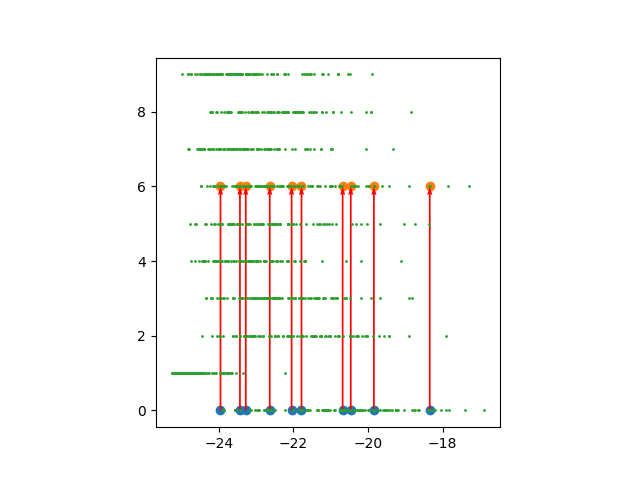

In [12]:

plot_iterations = 1

mapped_tensor = zh_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

my_plot(zh_start_tensor, mapped_tensor, zh_target_tensor, plot_points=10, x_idx=x_idx, y_idx=y_idx, one_hot_y=one_hot_y)


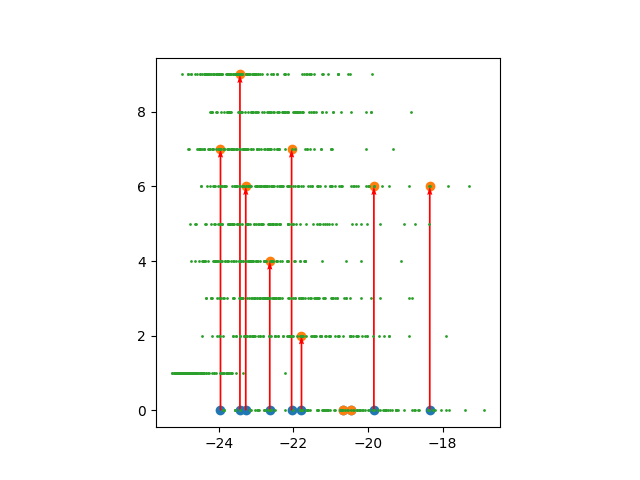

In [13]:
plot_iterations = iterations

mapped_tensor = zh_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

my_plot(zh_start_tensor, mapped_tensor, zh_target_tensor, plot_points=10, x_idx=x_idx, y_idx=y_idx, one_hot_y=one_hot_y)

# Path

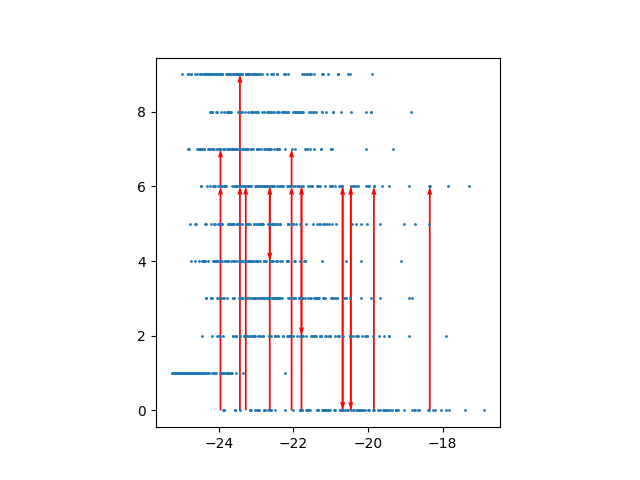

In [14]:
plot_points = 10


mapped_tensors = [zh_start_tensor[:plot_points, :]]
for i in range(iterations):
    mapped_tensors.append(map(mapped_tensors[i]).detach())


plt.figure()

for i, mapped_tensor in enumerate(mapped_tensors):
    if i > 0:
        start = mapped_tensors[i-1]
        mapped = mapped_tensors[i]

        start_x, mapped_x, target_x = project(start, mapped, zh_target_tensor, idx=x_idx)
        start_y, mapped_y, target_y = project(start, mapped, zh_target_tensor, idx=y_idx, one_hot=one_hot_y)

        dx = mapped_x-start_x
        dy = mapped_y-start_y
        plt.quiver(start_x, start_y, dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(target_x, target_y, s=1)

plt.gca().set_aspect('equal')
plt.show()

# Testing data

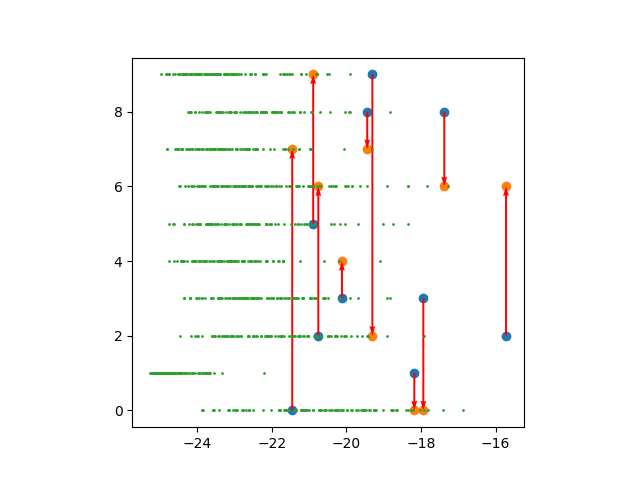

In [15]:
zh_start_tensor_test = zh_start_tensor+torch.rand_like(zh_start_tensor)*0.2
mapped_tensor = zh_start_tensor_test
for i in range(iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

my_plot(zh_start_tensor_test, mapped_tensor, zh_target_tensor, plot_points=10, x_idx=x_idx, y_idx=y_idx, one_hot_y=one_hot_y)


In [16]:
for i in torch.randperm(zh_start_tensor.shape[0])[:5]:
    print(f'i = {i}')    
    print(zh_start_tensor_test[i,y_idx])
    print(mapped_tensor[i,y_idx])
    print(zh_target_tensor[i,y_idx])
    print(f'{torch.argmax(zh_start_tensor_test[i,y_idx])} -> {torch.argmax(mapped_tensor[i,y_idx])} -> {torch.argmax(zh_target_tensor[i,y_idx])}')



i = 16
tensor([0.2027, 0.1827, 0.2111, 0.1086, 0.1476, 0.2017, 0.2578, 0.1294, 0.2497,
        0.2143])
tensor([ 0.1032, -0.0189,  0.0349,  0.0318,  0.0069, -0.0849,  0.0039,  0.0584,
         0.8448,  0.0040])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
6 -> 8 -> 8
i = 937
tensor([0.1958, 0.1284, 0.2810, 0.2327, 0.2700, 0.2157, 0.2720, 0.2002, 0.1119,
        0.1927])
tensor([ 0.0054,  0.1490, -0.0080,  0.0222, -0.0170, -0.0506,  0.0140, -0.0479,
         0.0706,  0.8695])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
2 -> 9 -> 9
i = 460
tensor([0.2513, 0.2711, 0.2768, 0.1237, 0.1457, 0.2127, 0.2340, 0.2710, 0.1111,
        0.2782])
tensor([ 0.9291, -0.0064, -0.0119, -0.0411,  0.0020, -0.0047, -0.0072, -0.0120,
         0.0388,  0.0611])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
9 -> 0 -> 0
i = 369
tensor([0.2283, 0.1153, 0.1835, 0.1140, 0.1674, 0.1408, 0.2882, 0.1876, 0.2801,
        0.1640])
tensor([-0.0186, -0.0067,  0.0240,  0.0229, -0.0027,  0.0117, -0.0023,  0.096